# PREAMBLE
<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
from validphys.api import API
from validphys.loader import FallbackLoader as Loader
l = Loader()

# Definition of the input

In [2]:
fit="221207-ern-002"

theory_max = 236
theory_mid = 205
theory_min = 201

alphas_step_size = 0.003
alphas_central = 0.119

covmat_scaling_factor = 1

# COMPUTATION OF $\alpha_s$

In [3]:
fitpath = API.fit(fit=fit).path 
filterpath = fitpath / 'filter.yml'
import yaml
with open(filterpath) as f:
    filterfile = yaml.safe_load(f)
pdf_ori=filterfile['theorycovmatconfig']['pdf']

In [4]:
common_dict = dict(dataset_inputs={"from_": "fit"},
            fit=fit,
            use_cuts="fromfit",
            metadata_group="nnpdf31_process",)

In [5]:
#Inputs for central theory
inps_central = dict(theoryid=theory_mid,pdf=pdf_ori, use_t0=True, datacuts={"from_": "fit"}, t0pdfset={"from_": "datacuts"}, **common_dict)

In [6]:
#Inputs for plus theory
inps_plus = dict(theoryid=theory_max,pdf=pdf_ori,**common_dict)

In [7]:
#Inputs for minus theory
inps_minus = dict(theoryid=theory_min,pdf=pdf_ori,**common_dict)

In [8]:
#Inputs for central theory
inps_central_fit = dict(theoryid=theory_mid,pdf={"from_": "fit"},**common_dict)

In [9]:
#Experimental covariance matrix
aa = API.groups_covmat(**inps_central)

LHAPDF 6.4.0 loading /home/roy/miniconda3/envs/nnpdf/share/LHAPDF/221206-ern-002/221206-ern-002_0000.dat
221206-ern-002 PDF set, member #0, version 1


In [10]:
C = API.groups_covmat(**inps_central)

In [11]:
dsindex=API.groups_index(**inps_central)

In [12]:
datth_central = API.group_result_table_no_table(**inps_central)

LHAPDF 6.4.0 loading all 101 PDFs in set 221206-ern-002
221206-ern-002, version 1; 101 PDF members


In [13]:
datth_plus = API.group_result_table_no_table(**inps_plus)

In [14]:
datth_minus = API.group_result_table_no_table(**inps_minus)

In [15]:
datth_central_fit = API.group_result_table_no_table(**inps_central_fit)

LHAPDF 6.4.0 loading all 501 PDFs in set 221207-ern-002
221207-ern-002, version 1; 501 PDF members


In [16]:
th_replicas_fit=datth_central_fit.iloc[:,2:].to_numpy()

Computation of Eqs.(3.37)-(3.38) in [arXiv:2105.05114](https://arxiv.org/pdf/2105.05114.pdf)

In [17]:
beta_tilde = np.sqrt(covmat_scaling_factor)*(alphas_step_size/np.sqrt(2))*np.array([1,-1])
S_tilde = beta_tilde@beta_tilde

In [18]:
delta_plus  = (np.sqrt(covmat_scaling_factor)/np.sqrt(2))*(datth_plus["theory_central"] - datth_central["theory_central"]).to_numpy()
delta_minus = (np.sqrt(covmat_scaling_factor)/np.sqrt(2))*(datth_minus["theory_central"] - datth_central["theory_central"]).to_numpy()
beta = [delta_plus,delta_minus]
S_hat = beta_tilde@beta

In [19]:
S = np.outer(delta_plus,delta_plus)+np.outer(delta_minus,delta_minus)
S = pd.DataFrame(S,index=dsindex,columns=dsindex)
S = pd.DataFrame(S.values, index=C.index, columns=C.index)

/home/roy/github/NNPDF/nnpdf/validphys2/src/validphys/theorycovariance/output.py:94: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df.sort_index(0, inplace=True)
/home/roy/github/NNPDF/nnpdf/validphys2/src/validphys/theorycovariance/output.py:95: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df.sort_index(1, inplace=True)


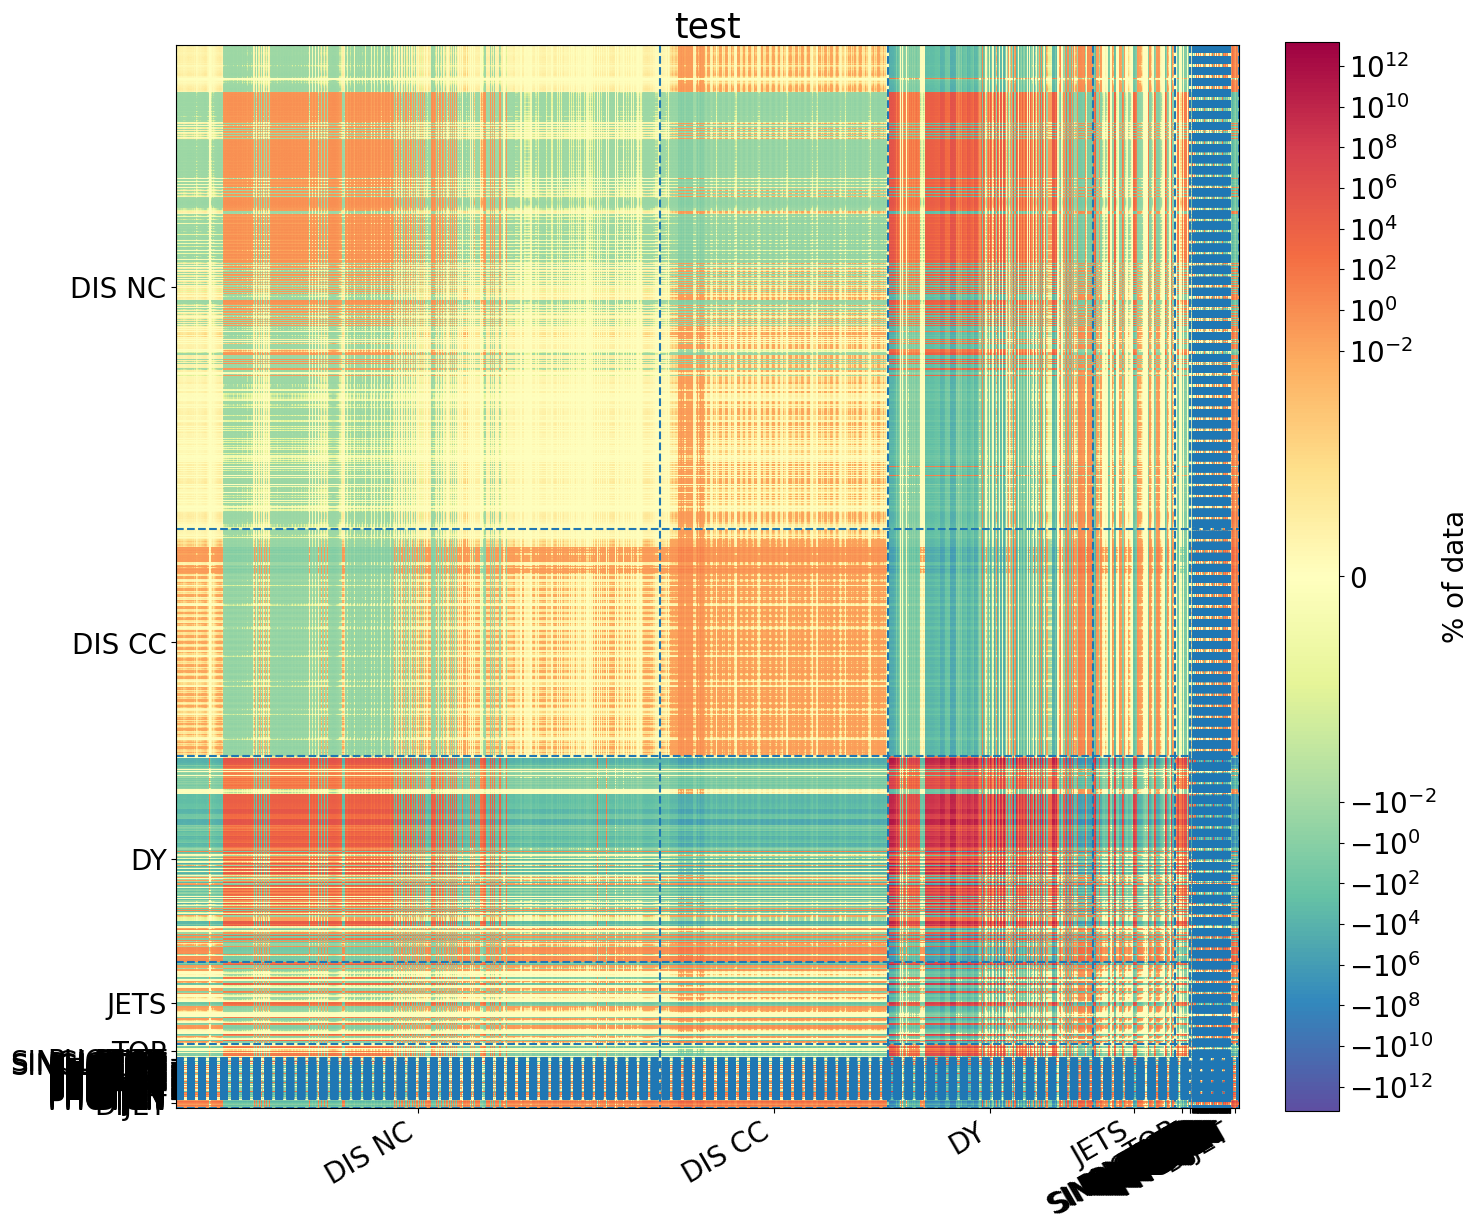

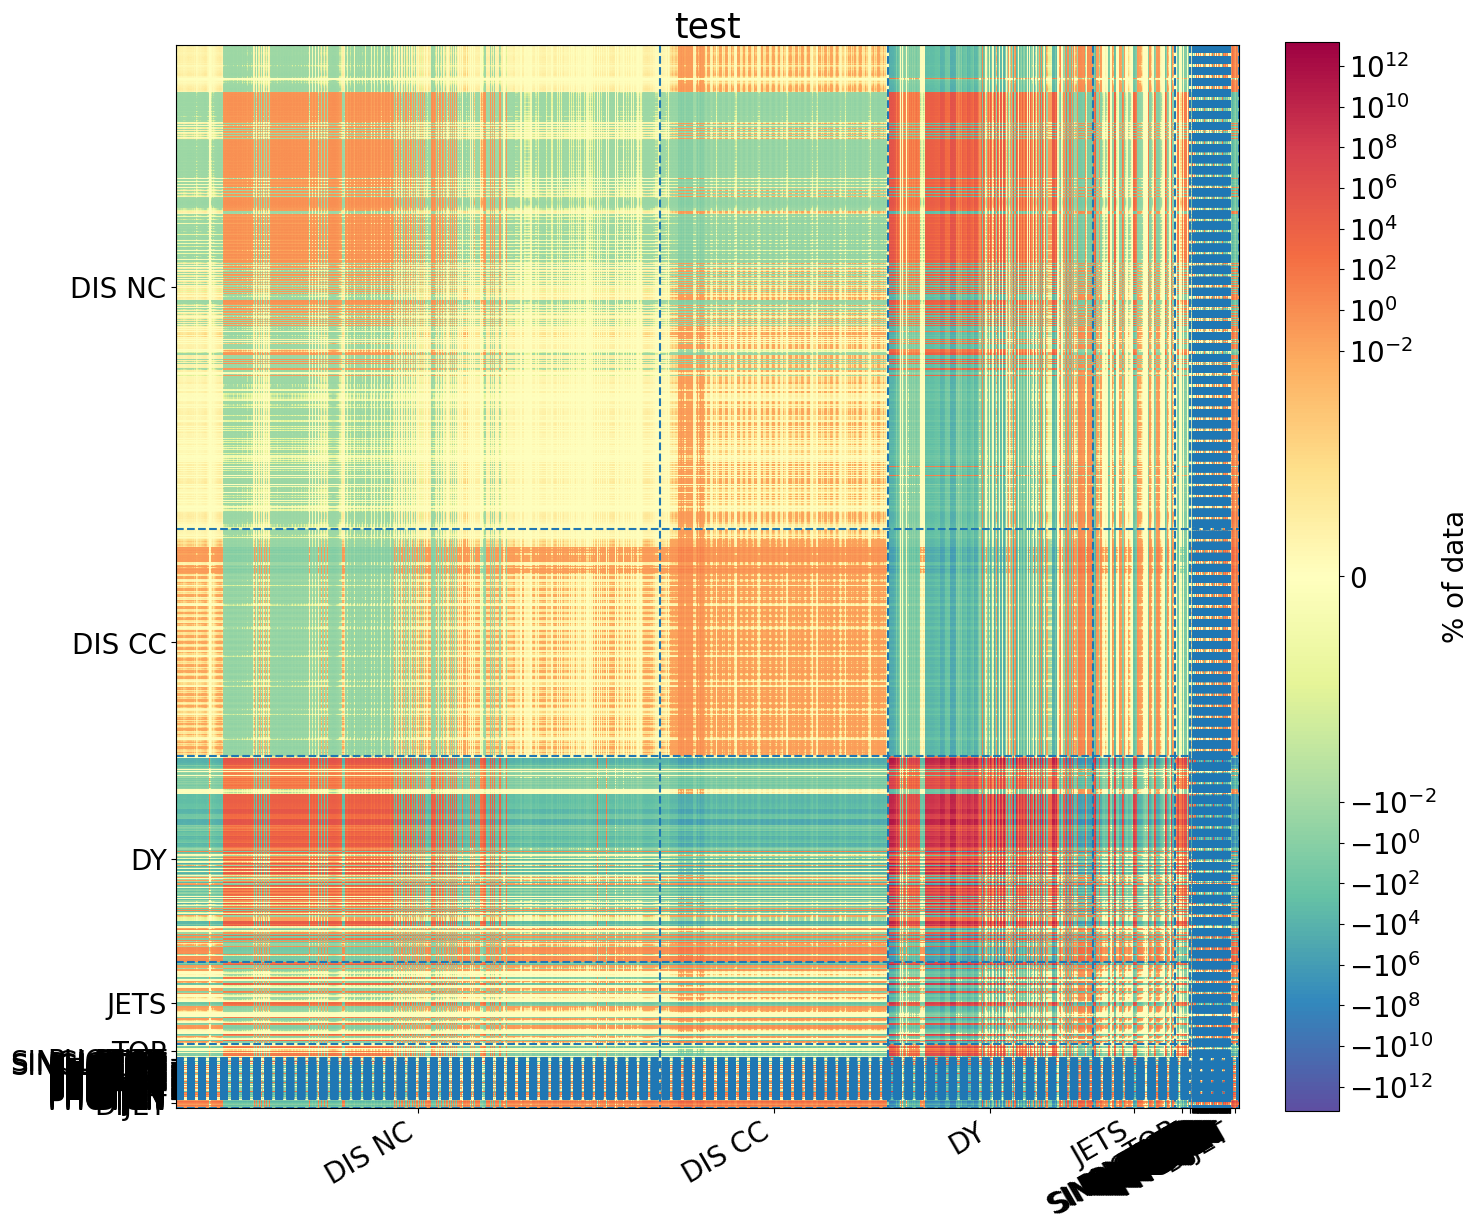

In [20]:
from validphys.theorycovariance.output import plot_covmat_heatmap, plot_corrmat_heatmap
plot_covmat_heatmap(S,'test')

/tmp/ipykernel_110148/1467711160.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


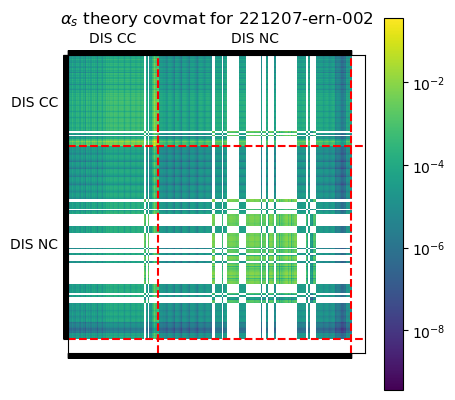

In [44]:
import matplotlib.pyplot as plt
import matplotlib

disonly_matrix = S.loc[np.in1d(S.columns.get_level_values(0), ['DIS CC', 'DIS NC']),np.in1d(S.columns.get_level_values(0), ['DIS CC', 'DIS NC'])]

plt.matshow(disonly_matrix,cmap='viridis',
    norm=matplotlib.colors.LogNorm(),
    interpolation="none",
)
plt.colorbar()
plt.title(rf"$\alpha_s$ theory covmat for {fit}")
ylabels, ylines = np.unique([i[0] for i in disonly_matrix.index],return_counts=True)
xlabels, xlines = np.unique([i[0] for i in disonly_matrix.columns],return_counts=True)

final_ylabels = ['']*len(disonly_matrix)
begin_line = 0
for label, line in zip(ylabels,ylines):
    label_position = int(begin_line + line / 2)
    final_ylabels[label_position] = label
    begin_line += line
    plt.axhline(y = begin_line, color = 'r', linestyle = '--')

final_xlabels = ['']*len(disonly_matrix)
begin_line = 0
for label, line in zip(xlabels,xlines):
    label_position = int(begin_line + line / 2)
    final_xlabels[label_position] = label
    begin_line += line
    plt.axvline(x = begin_line, color = 'r', linestyle = '--')

plt.xticks(range(len(disonly_matrix)), final_xlabels)
plt.yticks(range(len(disonly_matrix)), final_ylabels)

plt.savefig('nnpdf40_alphascovmat.pdf')


In [22]:
invcov = la.inv(C+S)

In [23]:
# Different from the prediction of the mean PDF (i.e. replica0)
mean_prediction = np.mean(th_replicas_fit[:],axis=1)

In [24]:
X = np.zeros_like(C.values)
for i in range(th_replicas_fit.shape[1]):
    X += np.outer((th_replicas_fit[:,i]-mean_prediction),(th_replicas_fit[:,i]-mean_prediction))
X *= 1/th_replicas_fit.shape[1]

Final result

In [25]:
# pseudoddata = API.read_pdf_pseudodata(**common_dict)

In [26]:
# BUG: dat_central should become average over data replicas
# dat_central=np.mean([i[0] for i in pseudoddata],axis=0).flatten()
dat_central = datth_central["data_central"]
delta_T_tilde = S_hat@invcov@(dat_central-mean_prediction)
P_tilde = S_hat.T@invcov@X@invcov@S_hat + (S_tilde - S_hat.T@invcov@S_hat)
pred = alphas_central + delta_T_tilde
unc  = np.sqrt(P_tilde)

In [27]:
aa = pd.read_csv(
    fitpath / 'tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv', 
    sep='\t',encoding='utf-8', index_col=2,header=3,skip_blank_lines=False,
);
if np.allclose(S.to_numpy(),aa.to_numpy()[:,2:].astype('float64')):
    print(rf"Prediction for $\alpha_s$: {pred:.5f} +/- {unc:.5f}")
else:
    print("Reconstructed theory covmat, S, is note the same as the stored covmat!")

Reconstructed theory covmat, S, is note the same as the stored covmat!
